In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

$$d{\Pi_{s}} = \kappa_{\Pi} \left(\theta_{\Pi}(s) + \frac{1}{\kappa_{\Pi}} \frac{d\theta_{\Pi}}{ds}(s) - \Pi_s\right) ds + \sigma_{\Pi, v} \Pi_s dB_{v, s} + \sigma_{\Pi, \Pi} \Pi_s dB_{\Pi, s}$$

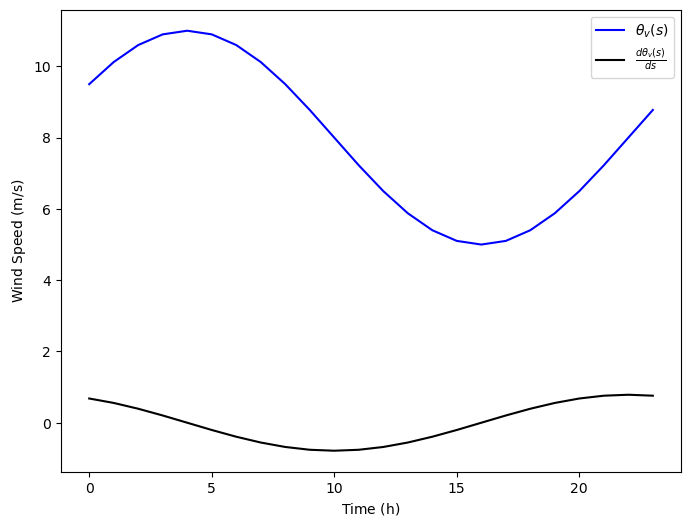

In [2]:
T = 24
h = 1
N = int(T / h)
k_pi = 0.04 / h
sigma_pi_v = 0.01
sigma_pi_pi = 0.075

theta_v_bar = 8
alpha_v = 0.375
gamma = np.pi / (12 * h)
psi_v = 2 / h

theta_v = lambda s: theta_v_bar * (1 + alpha_v * np.sin(gamma*(s + psi_v)))
dtheta_v = lambda s: theta_v_bar * alpha_v * np.cos(gamma * (s + psi_v)) * gamma
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, T, h), theta_v(np.arange(0, T, h)), color = "blue", label = r'$\theta_v(s)$')
plt.plot(np.arange(0, T, h), dtheta_v(np.arange(0, T, h)), color = "black", label = r'$\frac{d\theta_v(s)}{ds}$')
plt.xlabel(r'$\text{Time (h)}$')
plt.ylabel(r'$\text{Wind Speed (m/s)}$')
plt.legend()
plt.show()

In [40]:
def price_sde(T, N, k_pi, sigma_pi_v, sigma_pi_pi, simulation_times=None, wind_BM = None, price_BM = None):

    '''
    Simulation of the price process

    Inputs: 
    T: total time
    N: number of steps
    k_pi: mean reversion rate for price
    sig_pi_v: correlation of electricity price and wind speed
    sig_pi_pi: volatility of the price process
    simulation_times: how many times to simulate the process, default None
    wind_BM: standard brownian motion for the wind power, default None
    price_BM: standard brownian motion for the spot price, default None

    Output:
    A matrix containing the price of electricity at each time point
    '''
    h = T / N
    
    if price_BM is None or wind_BM is None:
        if price_BM is None: 
            price_BM = np.random.normal(0, np.sqrt(h), size = (simulation_times, N))
        
        if wind_BM is None:
            wind_BM = np.random.normal(0, np.sqrt(h), size = (simulation_times, N))
    else:
        h = T / np.size(price_BM[0, :])
    
    theta_v = lambda s: theta_v_bar * (1 + alpha_v * np.sin(gamma*(s + psi_v)))
    dtheta_v = lambda s: theta_v_bar * alpha_v * np.cos(gamma * (s + psi_v)) * gamma

    s = 0 
    price = np.zeros((simulation_times, N + 1))
    price[:, 0] = np.random.normal(theta_v(0), 0.075, simulation_times)
    
    for i in range(0, N):
        price[:, i+1] = price[:, i] + k_pi * (theta_v(s) + 1/k_pi * dtheta_v(s) - price[:, i]) * h \
            + np.sqrt(h) * sigma_pi_v * price[:, i] * wind_BM[:, i] \
            + np.sqrt(h) * sigma_pi_pi * price[:, i] * price_BM[:, i]
        s += h
    return price


In [41]:
T = 24
N = 24
h = T / N
k_pi = 0.04 / h
sigma_pi_v = 0.01
sigma_pi_pi = 0.075
simulation_times = 10000
price_process = price_sde(T, N, k_pi, sigma_pi_v, sigma_pi_pi, simulation_times, wind_BM = None, price_BM = None)
price_process

array([[ 9.51990234,  9.66456886, 10.2104193 , ...,  6.12862976,
         7.30423607,  8.17120752],
       [ 9.47428525, 10.36112741, 10.67383765, ...,  8.16640609,
         9.15598705, 10.52174279],
       [ 9.49198186, 10.79842839, 11.67890777, ...,  7.02678106,
         7.85259751, 10.27729211],
       ...,
       [ 9.59620103, 10.57138543, 10.51021217, ...,  6.3295934 ,
         7.13237169,  8.67170954],
       [ 9.50757925, 10.04492083, 11.74081005, ...,  9.6908653 ,
        10.0469882 , 11.0189915 ],
       [ 9.42386521, 10.03346303,  9.93383534, ...,  7.57274926,
         7.94779363,  8.28884263]])

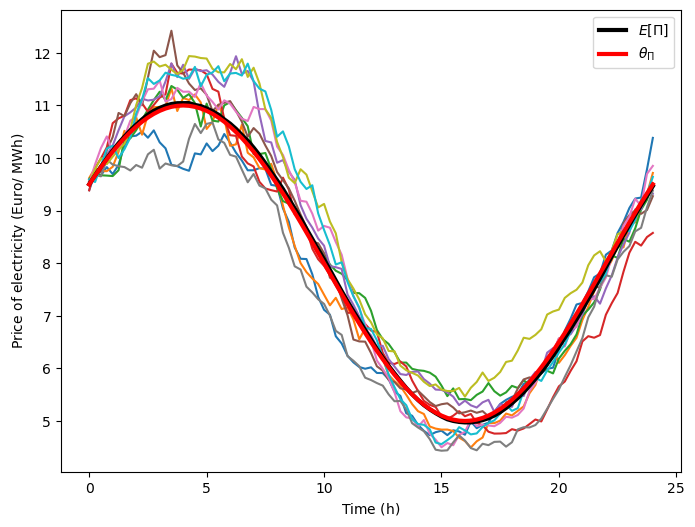

In [42]:
# simulations
T = 24
N = 96
h = T/N
k_pi = 0.04 / h
sigma_pi_v = 0.01
sigma_pi_pi = 0.075
simulations= 1000
prices1 = price_sde(T, N, k_pi, sigma_pi_v, sigma_pi_pi, simulation_times=simulations, wind_BM = None, price_BM = None)

plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(np.arange(0, T+h, h), prices1[i])
expected_value = np.mean(prices1, axis=0)
#print(expected_value)
plt.plot(np.arange(0, T+h, h), expected_value, linewidth = 3, color="black", label=r'$E[\Pi]$')
plt.plot(np.arange(0, T+h, h), theta_v(np.arange(0, T+h, h)), linewidth = 3, color="red", label = r'$\theta_{\Pi}$')
plt.xlabel(r'$\text{Time (h)}$')
plt.ylabel(r'$\text{Price of electricity (Euro/ MWh)}$')
plt.legend(loc='upper right')
plt.show()

In [43]:
T = 24
N = 96
h = T / N
k_pi = 0.04 / h
sigma_pi_v = 0.01
sigma_pi_pi = 0.075
simulationtimes = 10000

cov = np.reshape(np.array([1, 0, 0, 1]), (2, 2))
BM = np.random.multivariate_normal([0,0], cov, size = (simulationtimes, N))
windBM = BM[:, :, 0]
priceBM = BM[:, :, 1]
prices2 = price_sde(T, N, k_pi, sigma_pi_v, sigma_pi_pi, simulationtimes, windBM, priceBM)
# prices2
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, T+h, h), prices2[0], color="blue", label = r'$\theta_{\Pi}(s)$')
plt.xlabel(r'$\text{Time (h)}$')
plt.ylabel(r'$\text{Price of electricity (Euro/ MWh)}$')
plt.legend(loc='upper right')
plt.show()

array([[ 9.34260069,  9.22854679,  9.35801682, ...,  7.82452509,
         7.78485289,  7.88450117],
       [ 9.4990963 , 10.33738236, 10.44886154, ...,  9.53181404,
         9.77105381, 10.12340682],
       [ 9.50755269, 10.38296149,  9.92608203, ..., 10.82969447,
        10.53621712, 10.15390943],
       ...,
       [ 9.4510241 ,  9.80445499, 10.22155439, ...,  9.44339259,
         9.78071701,  9.92284243],
       [ 9.47599186,  9.81205585,  9.62438885, ..., 10.57529266,
        10.52806919, 10.42482852],
       [ 9.44678449,  9.63110425,  9.73500233, ...,  9.19677967,
         9.37566596,  9.43636654]])

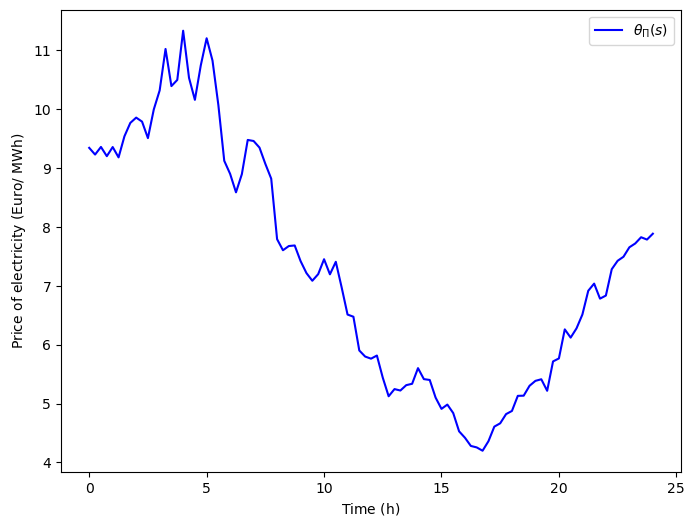

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, T+h, h), prices2[0], color="blue", label = r'$\theta_{\Pi}(s)$')
plt.xlabel(r'$\text{Time (h)}$')
plt.ylabel(r'$\text{Price of electricity (Euro/ MWh)}$')
plt.legend(loc='upper right')
plt.show()

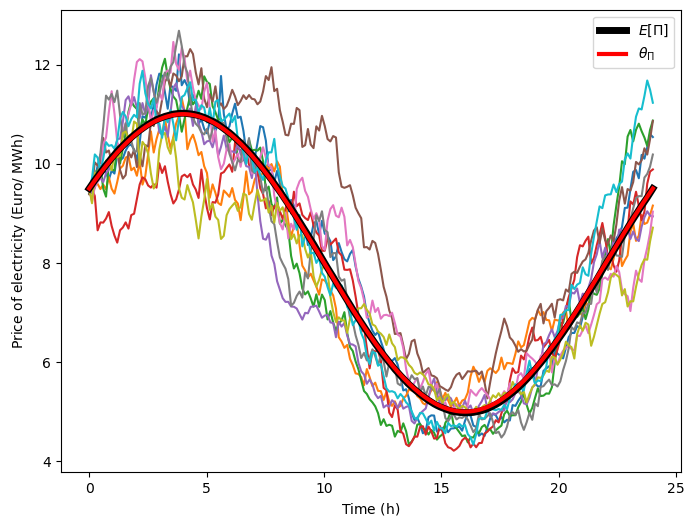

In [45]:
T = 24
N = 201
h = T / N
k_pi = 0.04 / h
sigma_pi_v = 0.01
sigma_pi_pi = 0.075
simulation_times = 10000

cov = np.reshape(np.array([1, 0, 0, 1]), (2, 2))
BM = np.random.multivariate_normal([0,0], cov, size = (simulation_times, N))
wind_BM = BM[:, :, 0]
price_BM = BM[:, :, 1]
plt.figure(figsize=(8, 6))
prices3 = price_sde(T, N, k_pi, sigma_pi_v, sigma_pi_pi, simulation_times, wind_BM, price_BM)
for i in range(10):
    plt.plot(np.arange(0, T+h, h), prices3[i])
expected_value = np.mean(prices3, axis=0)
#print(expected_value)
plt.plot(np.arange(0, T+h, h), expected_value, linewidth = 5, color="black", label=r'$E[\Pi]$')
plt.plot(np.arange(0, T+h, h), theta_v(np.arange(0, T+h, h)), linewidth = 3, color="red", label = r'$\theta_{\Pi}$')
plt.xlabel(r'$\text{Time (h)}$')
plt.ylabel(r'$\text{Price of electricity (Euro/ MWh)}$')
plt.legend(loc='upper right')
plt.show()